# Transcription Factor Analysis

We will explore and analyze gene expression data using the Seurat package in R.
Our goal is to gain insights into the transcription factors (TFs) that play a crucial role in gene regulation.
By understanding the TFs involved in gene regulation, we can gain insights into various biological processes, such as development, disease, and cellular responses.

We will identify key TFs, and analyze their expression patterns across clusters.

In [1]:
#### Load libraries ####
library(Seurat)
library(dplyr)
library(ggplot2)
library(org.Hs.eg.db)  # for gene annotation
library(AnnotationDbi)  # for gene annotation

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following object is masked from 'package:SeuratObject':

    intersect


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep

In [2]:
#### Load data ####
source(file.path("..", "preprocessing", "load_and_prepare_data.R"))

expression_matrix <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_umi_matrix.csv.gz"
)
metadata_path <- file.path(
  "..",
  "data",
  "GSE109816_normal_heart_cell_cluster_info.txt"
)

# standard Seurat preprocessing
seu_obj <- adult_human_heart(
  expression_matrix = expression_matrix,
  metadata_path = metadata_path
)


Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand


New names:
• `` -> `...1`
Rows: 54750 Columns: 9995
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): ...1
dbl (9994): SC_92563_0_69, SC_92563_0_17, SC_92563_0_23, SC_92563_0_12, SC_9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 7495 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): ID, Condition, Group, Cluster_ID, CellType
dbl (2): nGene, nUMI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Normalizing layer: counts

Finding variable features for la

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9312
Number of edges: 323604

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8992
Number of communities: 15
Elapsed time: 0 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:47:40 UMAP embedding parameters a = 0.9922 b = 1.112

13:47:40 Read 9312 rows and found 10 numeric columns

13:47:40 Using Annoy for neighbor search, n_neighbors = 30

13:47:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:47:41 Writing NN index file to temp file C:\Users\dekel\AppData\Local\Temp\RtmpWc41CL\file6f441907772e

13:47:41 Searching Annoy index using 1 thread, search_k = 3000

13:47:43 Annoy recall = 100%

13:47:43 Commencing smooth kNN distance calibration using 1 thre

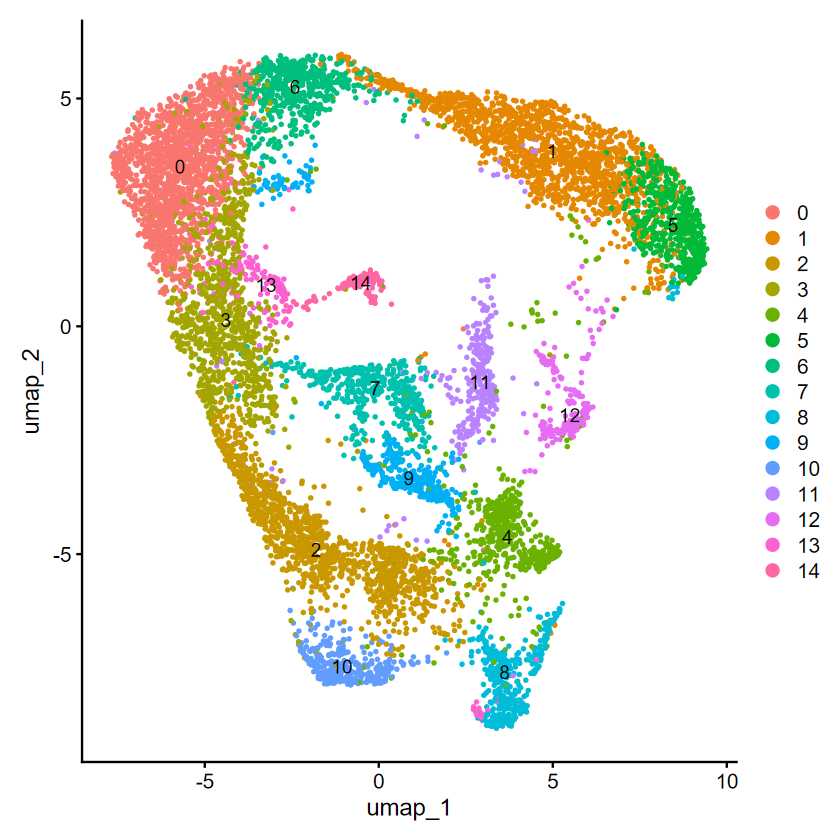

In [3]:
# Visualize clusters
DimPlot(seu_obj, reduction = "umap", label = TRUE, pt.size = 0.5)

Now that we loaded the data we can start observing TFs.
The simplest approach is to specify and plot specific TFs you want to observe for any changes.

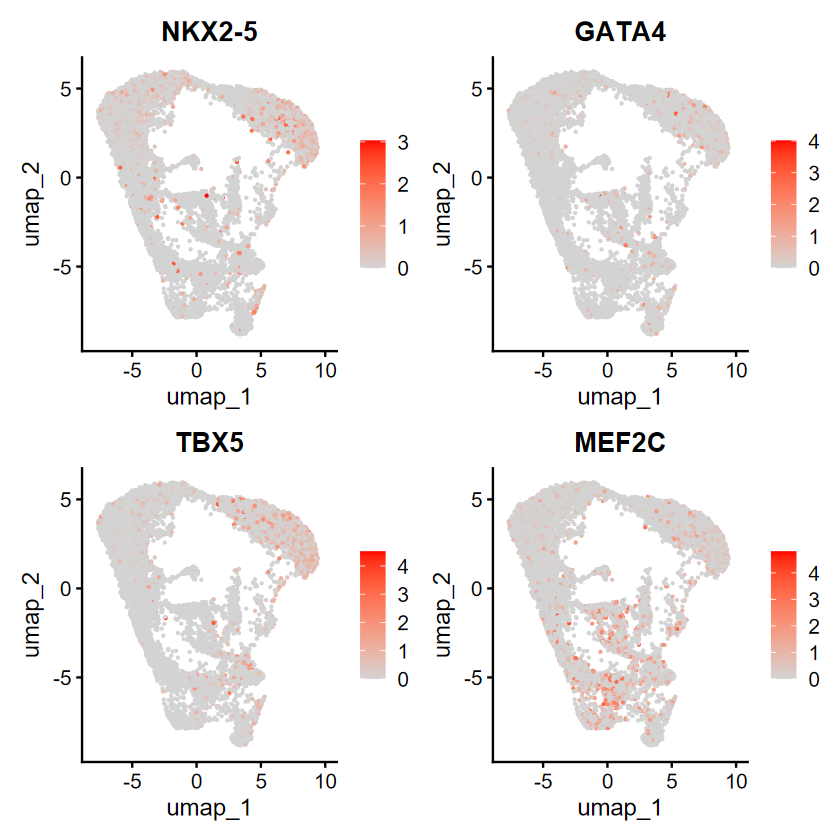

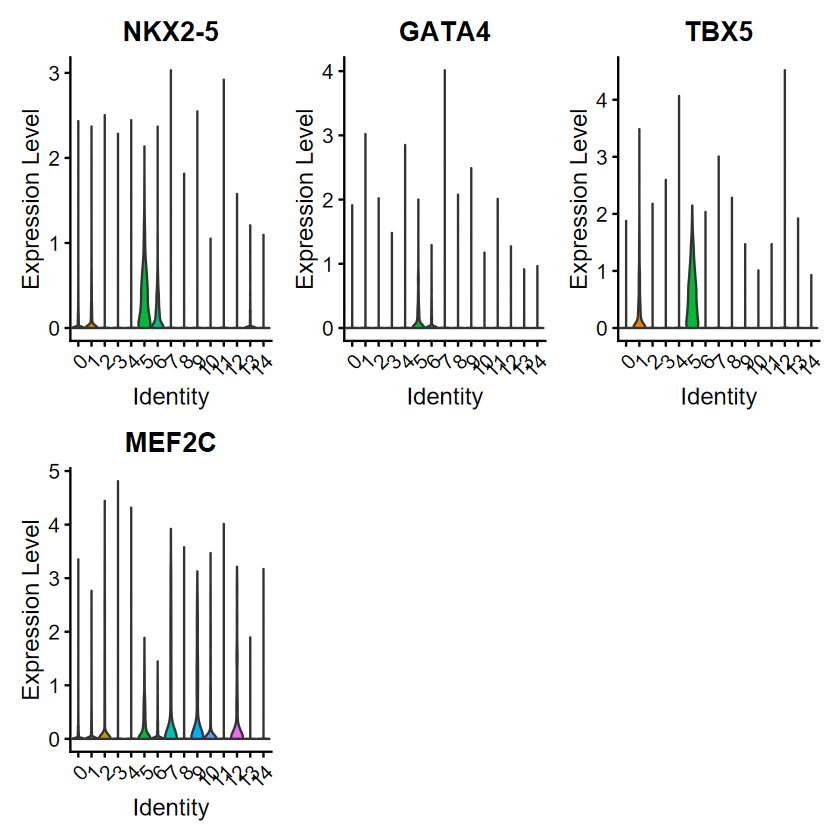

In [4]:
#### Feature plots of specific TFs ####
# Define key transcription factors
key_tfs <- c("NKX2-5", "GATA4", "TBX5", "MEF2C")

# Check if these genes are present in the dataset
key_tfs_present <- key_tfs[key_tfs %in% rownames(seu_obj)]

# Feature plots
FeaturePlot(seu_obj, key_tfs_present, cols = c("lightgrey", "red"))
# Violin plots
VlnPlot(seu_obj, key_tfs_present, pt.size = 0)


An unbiased approach can be to identify which TFs are unique to each cluster.

This might show which TFs are influencing clusters to be different from each other.

In [5]:
# Find markers specific to each cluster
heart_markers <- FindAllMarkers(seu_obj,
  only.pos = TRUE,
  min.pct = 0.25,
  logfc.threshold = 0.25
)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [6]:
library(biomaRt)

# Connect to the Ensembl BioMart database
mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

# Retrieve protein-coding genes associated with the GO term for DNA-binding transcription factor activity
tf_data <- getBM(
  attributes = c("hgnc_symbol", "gene_biotype"),
  filters = "go",
  values = "GO:0003700",
  mart = mart
)

# Filter to include only protein-coding genes
tf_genes <- unique(tf_data$hgnc_symbol[
  tf_data$gene_biotype == "protein_coding"
])

In [16]:
# Filter markers to include only transcription factors
tf_markers <- heart_markers %>%
  filter(gene %in% tf_genes)

#let's print the head of the result of some genes in tf_genes that are not present in the data assay of the Seurat object
print(head(tf_genes[!tf_genes %in% rownames(seu_obj@assays$RNA$data)]))

print(head(tf_genes))
print(length(tf_genes))
print(head(tf_markers))
print(nrow(tf_markers))
# print out if the Seurat data has in it's scaled data all of these gene names
print(sum(tf_markers$gene %in% rownames(seu_obj@assays$RNA$data)))
print(sum(tf_markers$gene %in% rownames(seu_obj@assays$RNA$scale.data)))

[1] "HSFX4" ""      "HSFX3" "SOX10" "TBXT"  "BMAL1"
[1] "HSFY2"  "HSFY1"  "SRY"    "RFX1"   "KLF5"   "ZNF660"
[1] 703
                p_val avg_log2FC pct.1 pct.2     p_val_adj cluster    gene
ONECUT3  4.442218e-87  0.3041940 0.670 0.378  2.124180e-82       0 ONECUT3
TBX5    1.012052e-166  1.6326706 0.514 0.189 4.839428e-162       1    TBX5
NFXL1    2.354558e-69  0.7590803 0.410 0.195  1.125903e-64       1   NFXL1
DDIT3    2.525549e-44  0.6466159 0.555 0.369  1.207667e-39       1   DDIT3
NKX2-5   3.283248e-35  0.7298755 0.386 0.235  1.569984e-30       1  NKX2-5
NFIC     5.784023e-30  0.4749593 0.486 0.332  2.765804e-25       1    NFIC
[1] 287
[1] 287
[1] 12


In [8]:
# Select top transcription factors per cluster
top_tf_markers <- tf_markers %>%
  group_by(cluster) %>%
  top_n(n = 10, wt = avg_log2FC)

print(top_tf_markers)

# Heatmap of top transcription factors unique to each cluster
DoHeatmap(seu_obj, features = top_tf_markers$gene)

# A tibble: 0 × 7
# Groups:   cluster [0]
# ℹ 7 variables: p_val <dbl>, avg_log2FC <dbl>, pct.1 <dbl>, pct.2 <dbl>,
#   p_val_adj <dbl>, cluster <fct>, gene <chr>


ERROR: Error in names(x) <- value: 'names' attribute [3] must be the same length as the vector [1]


In [ ]:
# gene regulatory network analysis with SCENIC and 

In [17]:
### Trying to sort out the mismatch in the names of TFs
#TODO: use this to understand if you need to change the rownames of the seurat object or if something is the underlying cause
library(dplyr)
library(org.Hs.eg.db)

# Map Seurat genes to HGNC symbols
seurat_genes <- rownames(seu_obj)
mapped_genes <- mapIds(
  org.Hs.eg.db,
  keys = seurat_genes,
  column = "SYMBOL",
  keytype = "ENSEMBL", # Change this if your keys are not Ensembl IDs
  multiVals = "first"
)

# Remove NA values
mapped_genes <- na.omit(mapped_genes)

# Update Seurat object rownames if necessary
rownames(seu_obj) <- mapped_genes

# Re-run your TF filtering
tf_markers <- heart_markers %>%
  filter(gene %in% tf_genes)


ERROR: Error in .testForValidKeys(x, keys, keytype, fks): None of the keys entered are valid keys for 'ENSEMBL'. Please use the keys method to see a listing of valid arguments.
